In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import widgets as wd

analysis = False
save = True

In [2]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [3]:
tdc, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [4]:
tdc_model = tdc.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/k_means/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_laserIntensity = data['dld/pulse_voltage'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [5]:
data

,dld/high_voltage,dld/pulse_voltage,dld/start_counter,dld/t,dld/x,dld/y
0,5261.248047,5261.248047,9299.0,634.893066,5.985306,-22.763265
1,5261.248047,5261.248047,9551.0,467.893908,-3.629388,17.032653
2,5261.248047,5261.248047,10161.0,649.486890,-17.828571,23.973061
3,5261.248047,5261.248047,10358.0,646.016742,19.038367,20.980408
4,5261.248047,5261.248047,10581.0,632.588778,22.476735,-6.176327
...,...,...,...,...,...,...
1822981,5708.472656,5708.472656,26372.0,618.042960,-19.993469,-22.922449
1822982,5708.472656,5708.472656,26455.0,612.954324,13.180408,18.751837
1822983,5708.472656,5708.472656,26564.0,453.642984,-8.309388,20.725714
1822984,5708.472656,5708.472656,26777.0,605.561400,18.274286,11.111020


In [149]:
# t0
dld_t = dld_t - t0

In [150]:
# Remove negative and zero TOF
threshold = 70
dld_highVoltage = dld_highVoltage[dld_t>threshold]
dld_laserIntensity = dld_laserIntensity[dld_t>threshold]
dld_x = dld_x[dld_t>threshold]
dld_y = dld_y[dld_t>threshold]
dld_t = dld_t[dld_t>threshold]

<IPython.core.display.Javascript object>


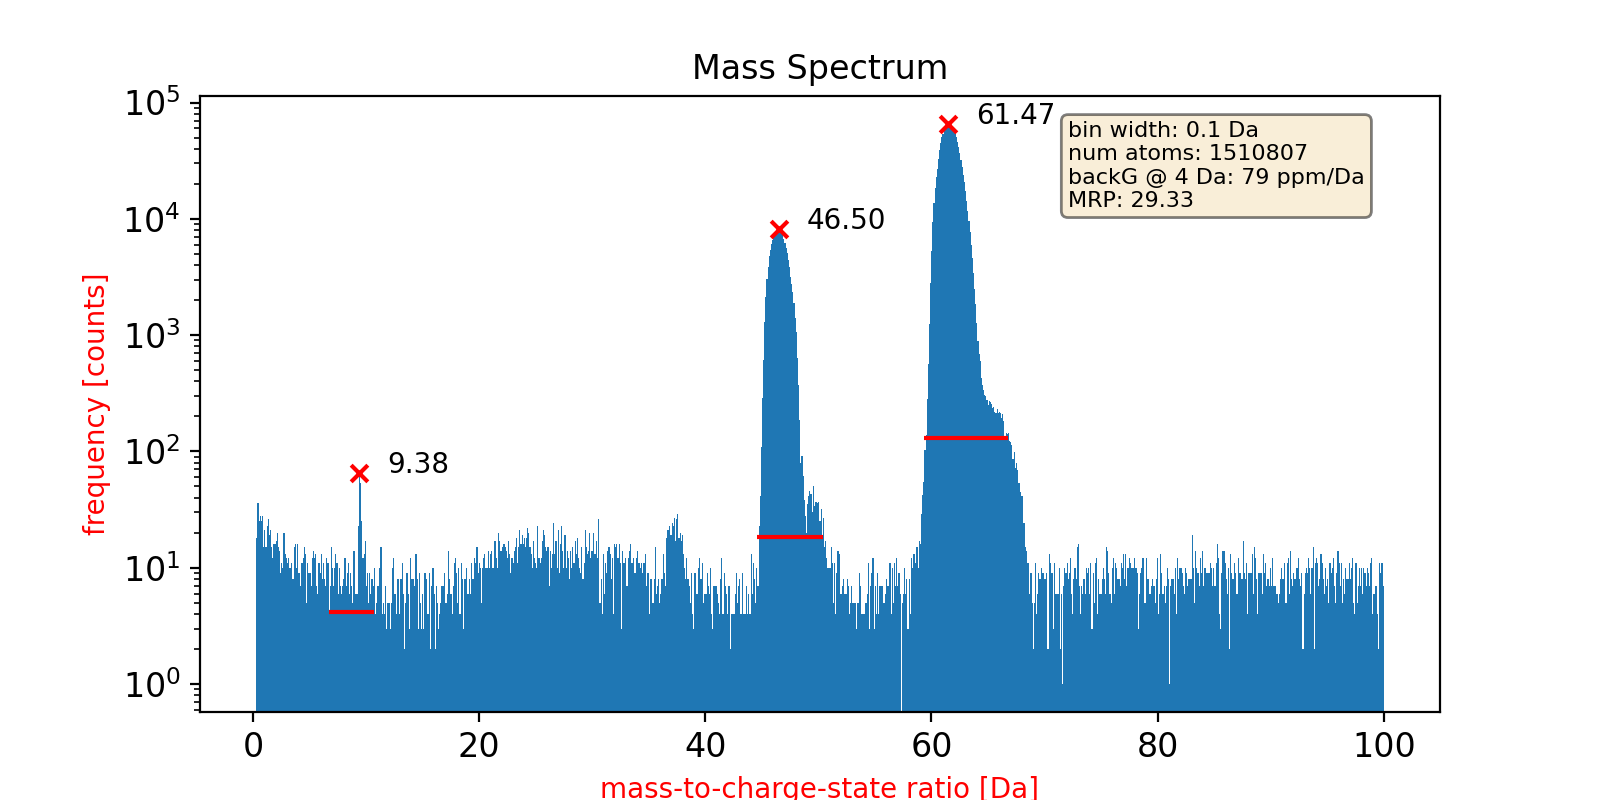

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [29.33439831]
Peaks  0 is: 9.38 peak window sides are: 9.28 - 9.58
Peaks  1 is: 46.50 peak window sides are: 45.50 - 47.40
Peaks  2 is: 61.47 peak window sides are: 60.47 - 62.57


In [128]:
mc_seb_ini = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_highVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist_ini, left_right_peaks_ini, peaks_sides_ini, max_paek_edges_ini, index_max_ini = tools.massSpecPlot(mc_seb_ini[mc_seb_ini < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name=figname)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))

In [145]:
param_bowl = np.array([ 1.00150733,  0.00501815, -0.01162992, -0.04243268,  0.00291546, -0.04091942])
param_vol = np.array([ 4.05267821e+02,  1.89082695e-05, -2.43722582e-01,  1.17441038e+03])

def voltage_corr(x, a, b, c, d):
#     return a / np.sqrt((b + (c * x) + (d * (x**2))))
    return (a / (b * (x ** 2) + c * x + d))

def bowl_corr_fit(data_xy, a, b, c, d, e, f):
    x = data_xy[0]
    y = data_xy[1]
#     result = np.sqrt(a + b*x + c*y + d*(x**2) + e*x*y + f*(y**2))
    result = (a + b*x + c*y + d*(x**2) + e*x*y + f*(y**2))
    return result

f_v = voltage_corr(dld_highVoltage, *param_vol)
scaler2 = MinMaxScaler(feature_range=(-1, 1))
dld_x_norm = scaler2.fit_transform(dld_x.reshape(-1, 1)).reshape((-1,)) 
dld_y_norm = scaler2.fit_transform(dld_y.reshape(-1, 1)).reshape((-1,)) 
f_bowl = bowl_corr_fit([dld_x_norm,dld_y_norm], *param_bowl)

dld_t = dld_t * f_bowl * f_v

<IPython.core.display.Javascript object>


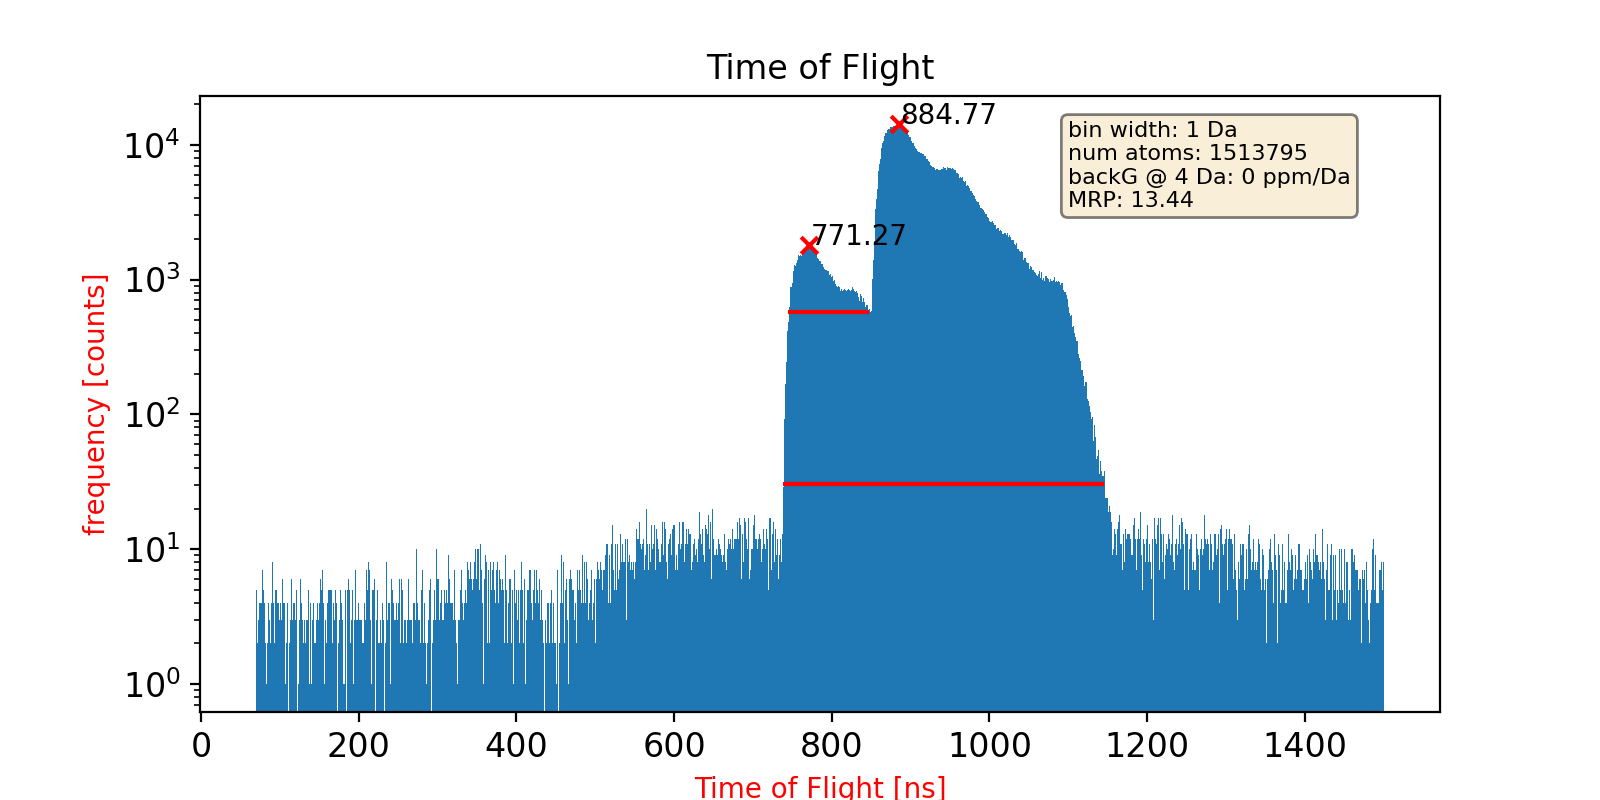

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [13.44450711]
Peaks  0 is: 771.27 peak window sides are: 748.38 - 805.61
Peaks  1 is: 884.77 peak window sides are: 859.02 - 924.83


In [151]:
max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t[dld_t < 1500], 1, distance=100, percent=50, prominence=100, plot=True, label='tof', fig_name=figname)
mrp = (max_hist_tof / (left_right_peaks_tof[1] - left_right_peaks_tof[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_tof)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_tof[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_tof[i,2], peaks_sides_tof[i,3]))

<IPython.core.display.Javascript object>


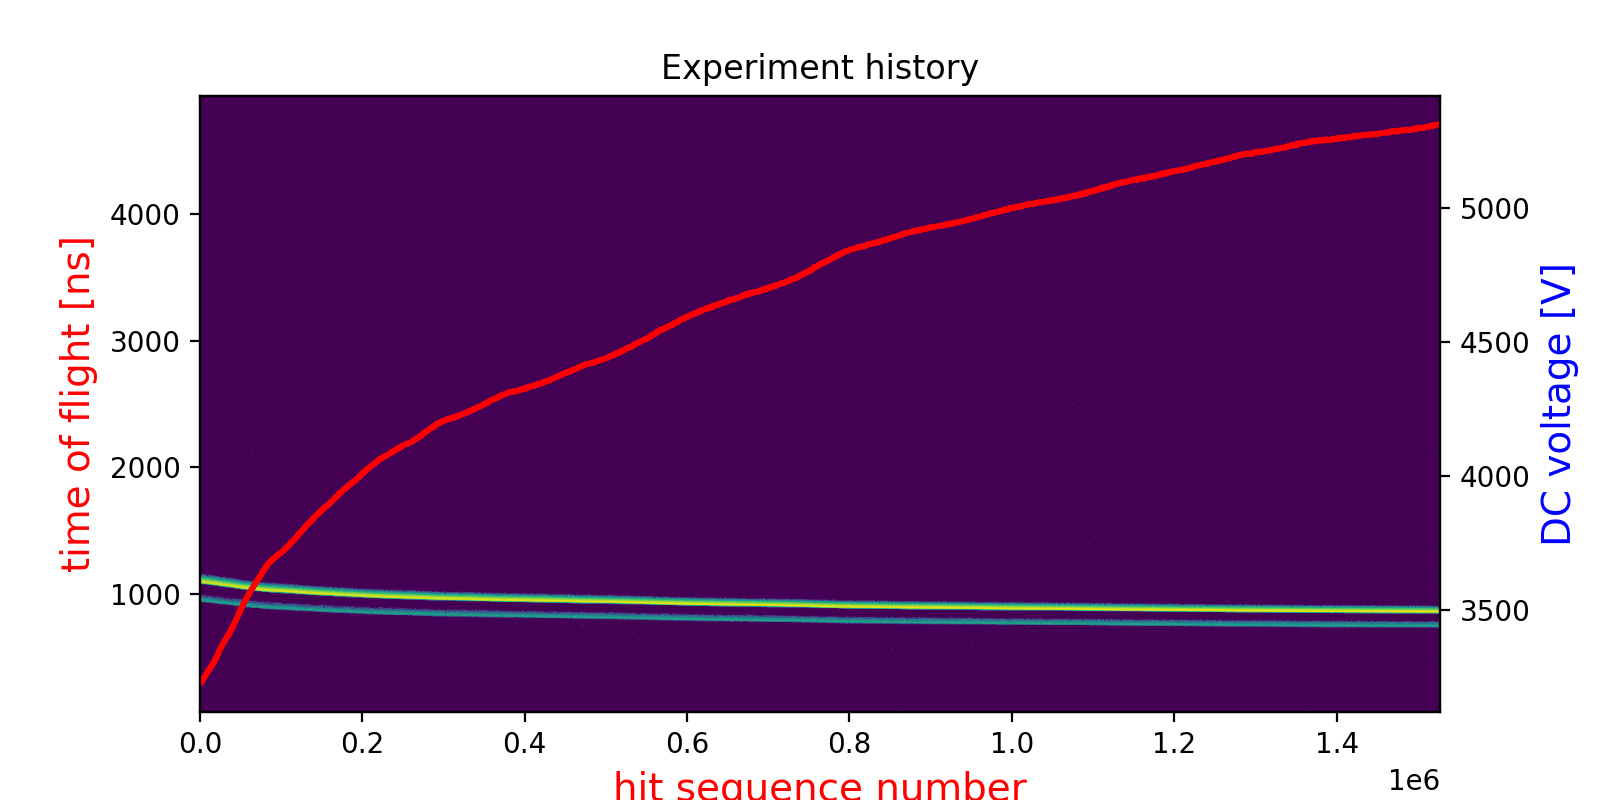

In [129]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

yaxis = dld_t[dld_t < 5000]  # dld_t
# y[y>5000] = 0
xaxis = np.arange(len(yaxis))
heatmap_i, xedges, yedges = np.histogram2d(xaxis, yaxis, bins=(1200, 800))
heatmap_i_log = np.copy(heatmap_i)
heatmap_i_log[heatmap_i_log == 0] = 1  # to have zero after apply log
heatmap_i_log = np.log(heatmap_i_log)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# set x-axis label
ax1.set_xlabel("hit sequence number", color="red", fontsize=14)
# set y-axis label
ax1.set_ylabel("time of flight [ns]", color="red", fontsize=14)
plt.title("Experiment history")
plt.imshow(heatmap_i_log.T, extent=extent, origin='lower', aspect="auto")

# plot high voltage curve
ax2 = ax1.twinx()

# dldGroupStorage[0] --> dld/high_voltage
high_voltage = dld_highVoltage[dld_t < 5000]
xaxis = np.arange(len(high_voltage))
ax2.plot(xaxis, high_voltage, color='r', linewidth=2)
ax2.set_ylabel("DC voltage [V]", color="blue", fontsize=14)
plt.show()

<IPython.core.display.Javascript object>


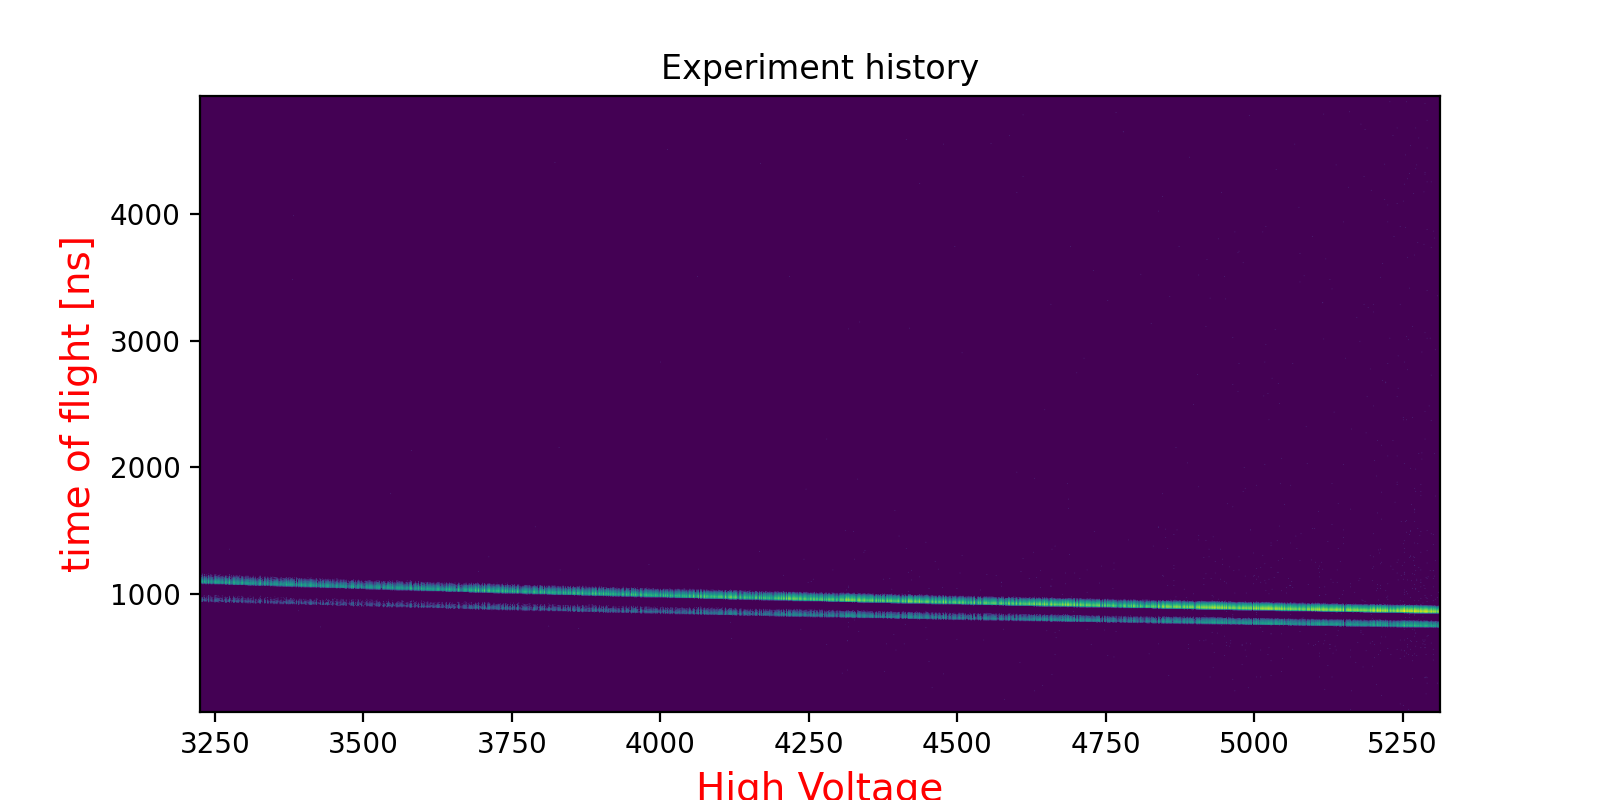

In [130]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

yaxis = dld_t[dld_t < 5000]  # dld_t
xaxis = dld_highVoltage[dld_t < 5000]

heatmap_v, xedges, yedges = np.histogram2d(xaxis, yaxis, bins=(1200, 800))
heatmap_v_log = np.copy(heatmap_v)
heatmap_v_log[heatmap_v == 0] = 1  # to have zero after apply log
heatmap_v_log = np.log(heatmap_v_log)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# set x-axis label
ax1.set_xlabel("High Voltage", color="red", fontsize=14)
# set y-axis label
ax1.set_ylabel("time of flight [ns]", color="red", fontsize=14)
plt.title("Experiment history")
plt.imshow(heatmap_v_log.T, extent=extent, origin='lower', aspect="auto")
plt.show()

<IPython.core.display.Javascript object>


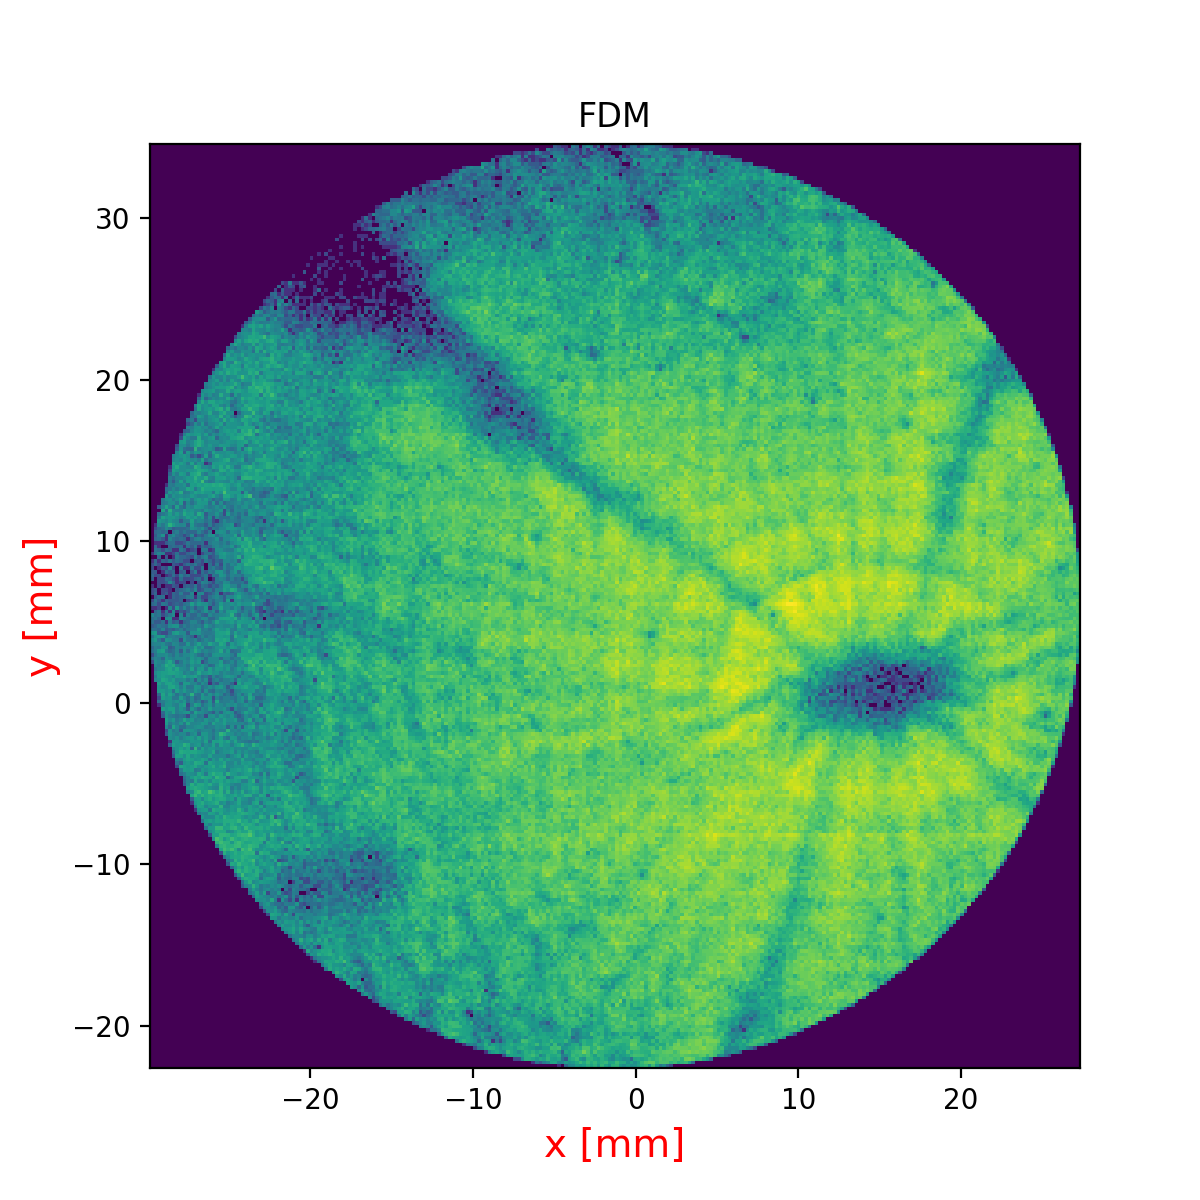

In [131]:
FDM, xedges, yedges = np.histogram2d(dld_x, dld_y, bins=(256,256))

FDM[FDM == 0] = 1  # to have zero after apply log
FDM = np.log(FDM)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig1, ax1 = plt.subplots(figsize=(6, 6))
# set x-axis label
ax1.set_xlabel("x [mm]", color="red", fontsize=14)
# set y-axis label
ax1.set_ylabel("y [mm]", color="red", fontsize=14)
plt.title("FDM")
plt.imshow(FDM.T, extent=extent, origin='lower', aspect="auto")

# if save_name != None:
#     plt.savefig("%s.png" % save_name, format="png", dpi=600)
#     plt.savefig("%s.svg" % save_name, format="svg", dpi=600)
plt.show()

<IPython.core.display.Javascript object>


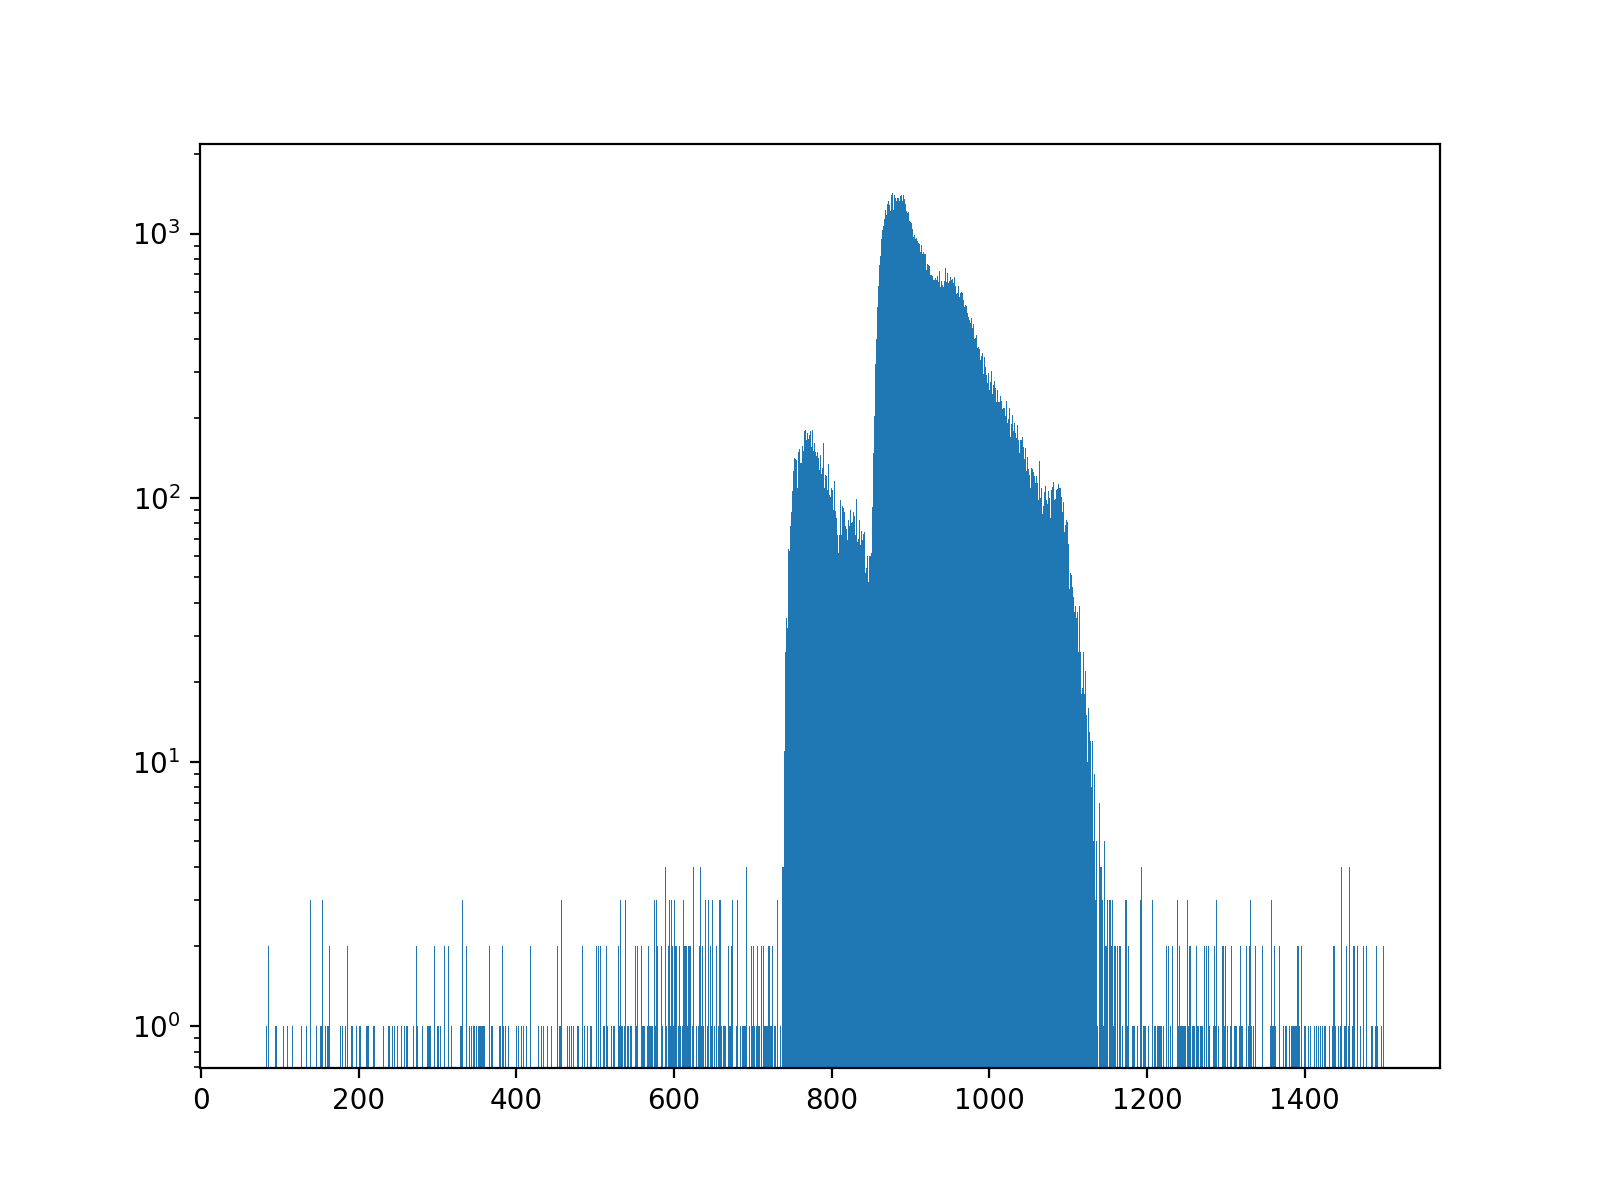

<IPython.core.display.Javascript object>


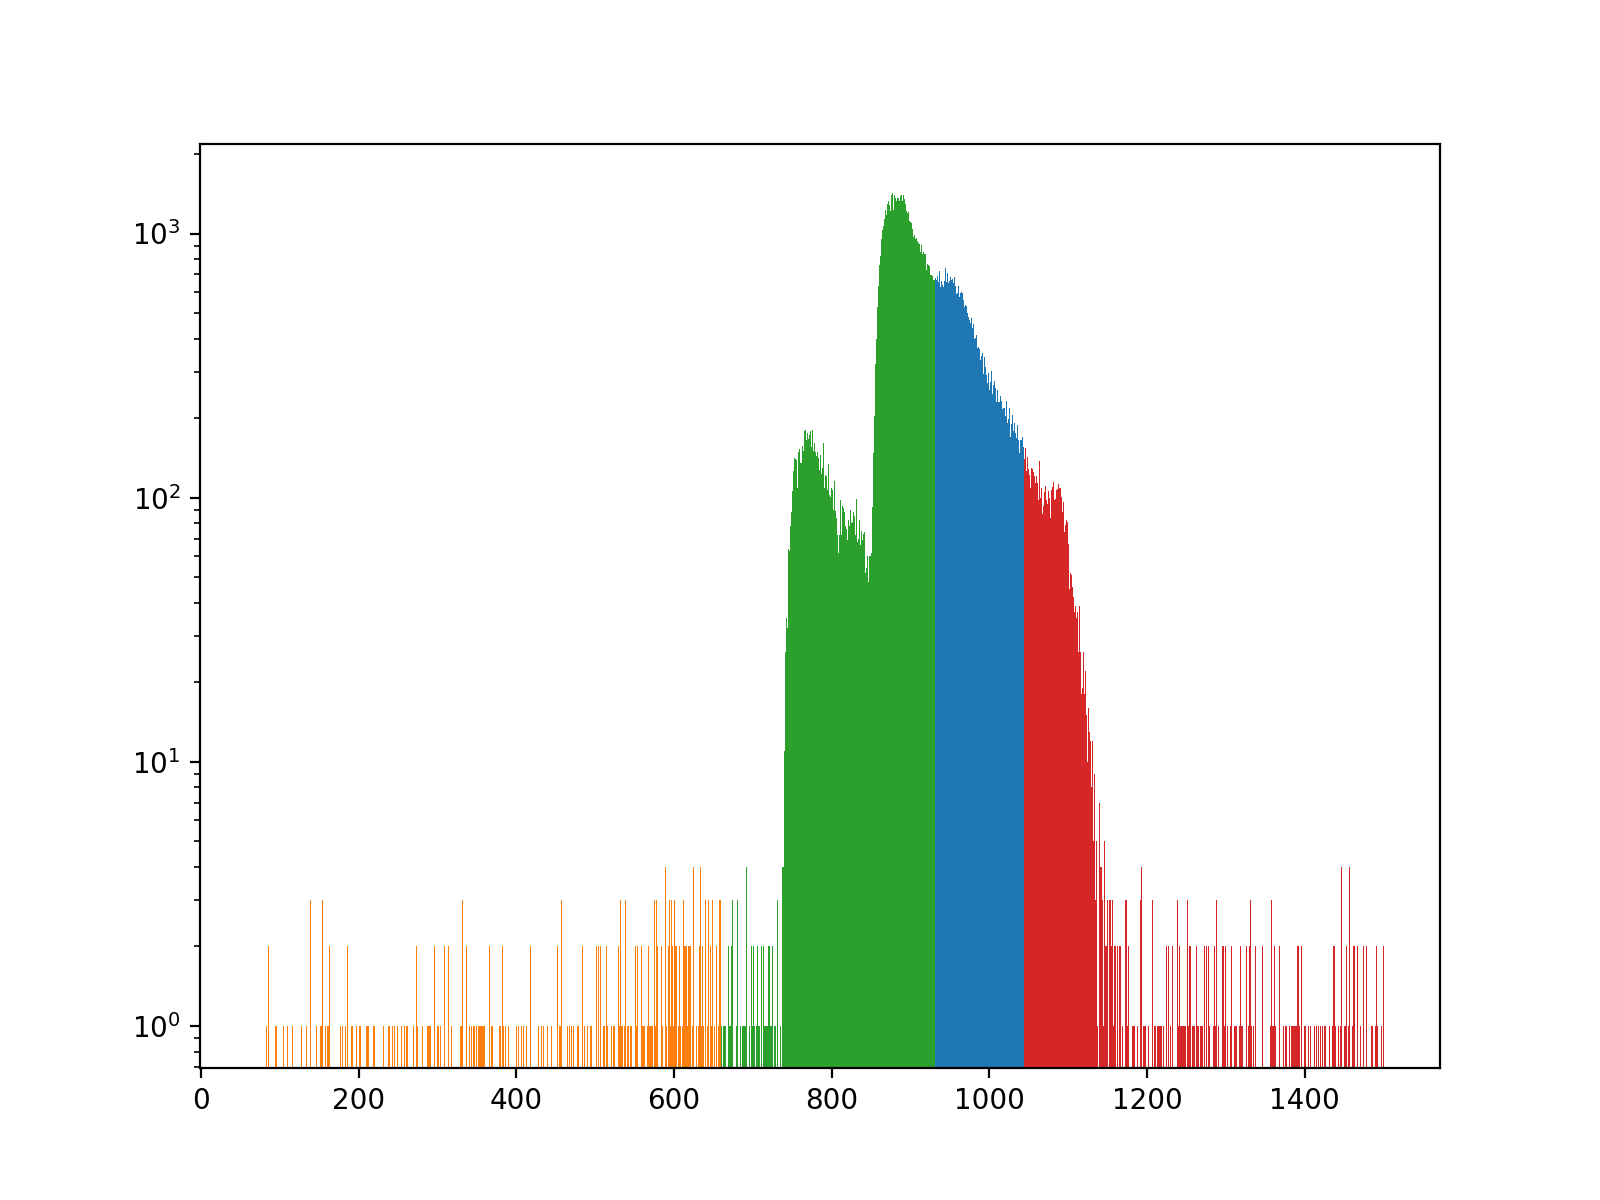

[[ 972.438  ]
 [ 436.41602]
 [ 881.57227]
 [1086.1362 ]]


In [135]:
tt = np.copy(dld_t[dld_t < 1500])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)
bins = 0.1
num_k = 4
bins = np.linspace(np.min(tt), np.max(tt), round(np.max(tt) / bins))
fig1, ax1 = plt.subplots(figsize=(8, 6))
plt.hist(tt, bins, log=True)
plt.show()


# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS
# Apply KMeans
compactness,labels,centers = cv2.kmeans(tt , num_k, None, criteria,10,flags)

fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(num_k):
    A = tt[labels==i]
    plt.hist(A, bins, log=True)
plt.hist(centers,bins, color='black')
plt.show()
print(centers)

<IPython.core.display.Javascript object>


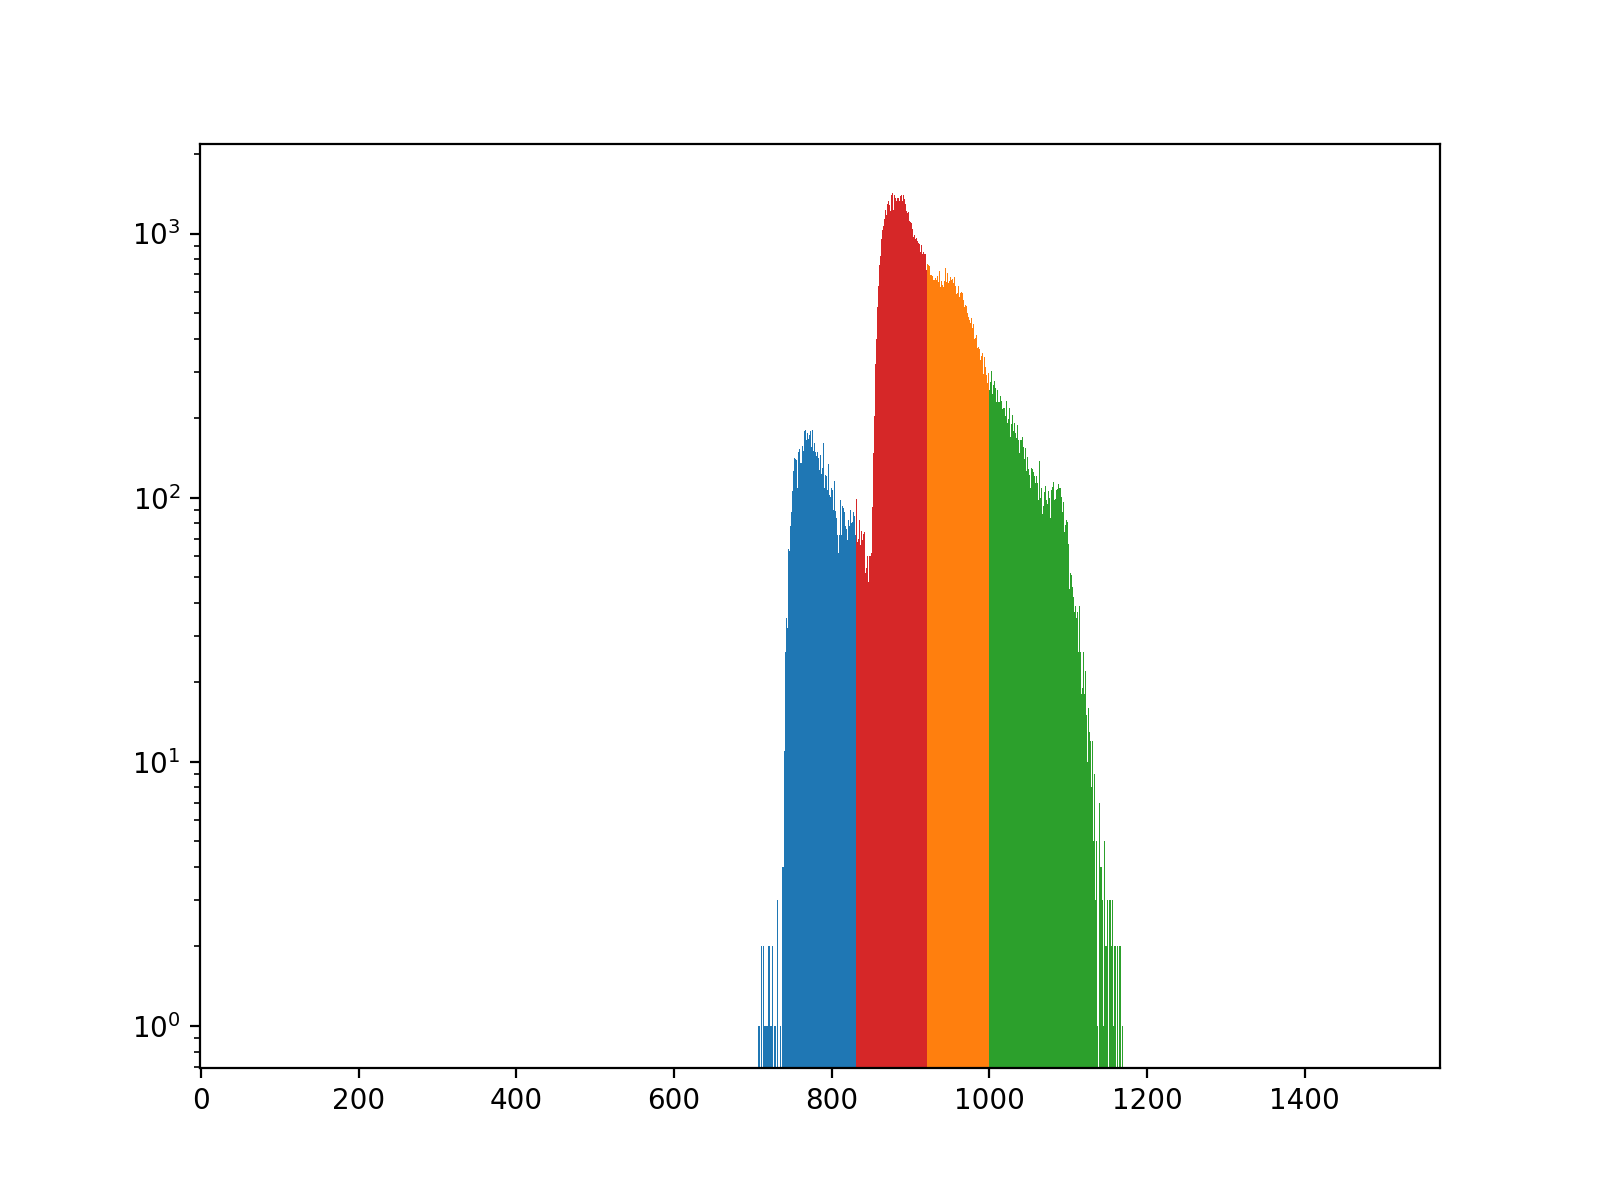

In [141]:
from sklearn import mixture
n_components = 5
tt = np.copy(dld_t[dld_t < 1500])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)
gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full').fit(tt)
labels = gmm.predict(tt)

fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(num_k):
    A = tt[labels==i]
    plt.hist(A, bins, log=True)
plt.show()

In [ ]:
from sklearn import mixture
tt = np.copy(dld_t[dld_t < 1000])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(tt)
labels = gmm.predict(tt)
fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(num_k):
    A = tt[labels==i]
    plt.hist(A, bins, log=True)
plt.show()

In [81]:
import time
from sklearn.cluster import KMeans
import cv2
from skimage import io
from sklearn import cluster

<IPython.core.display.Javascript object>


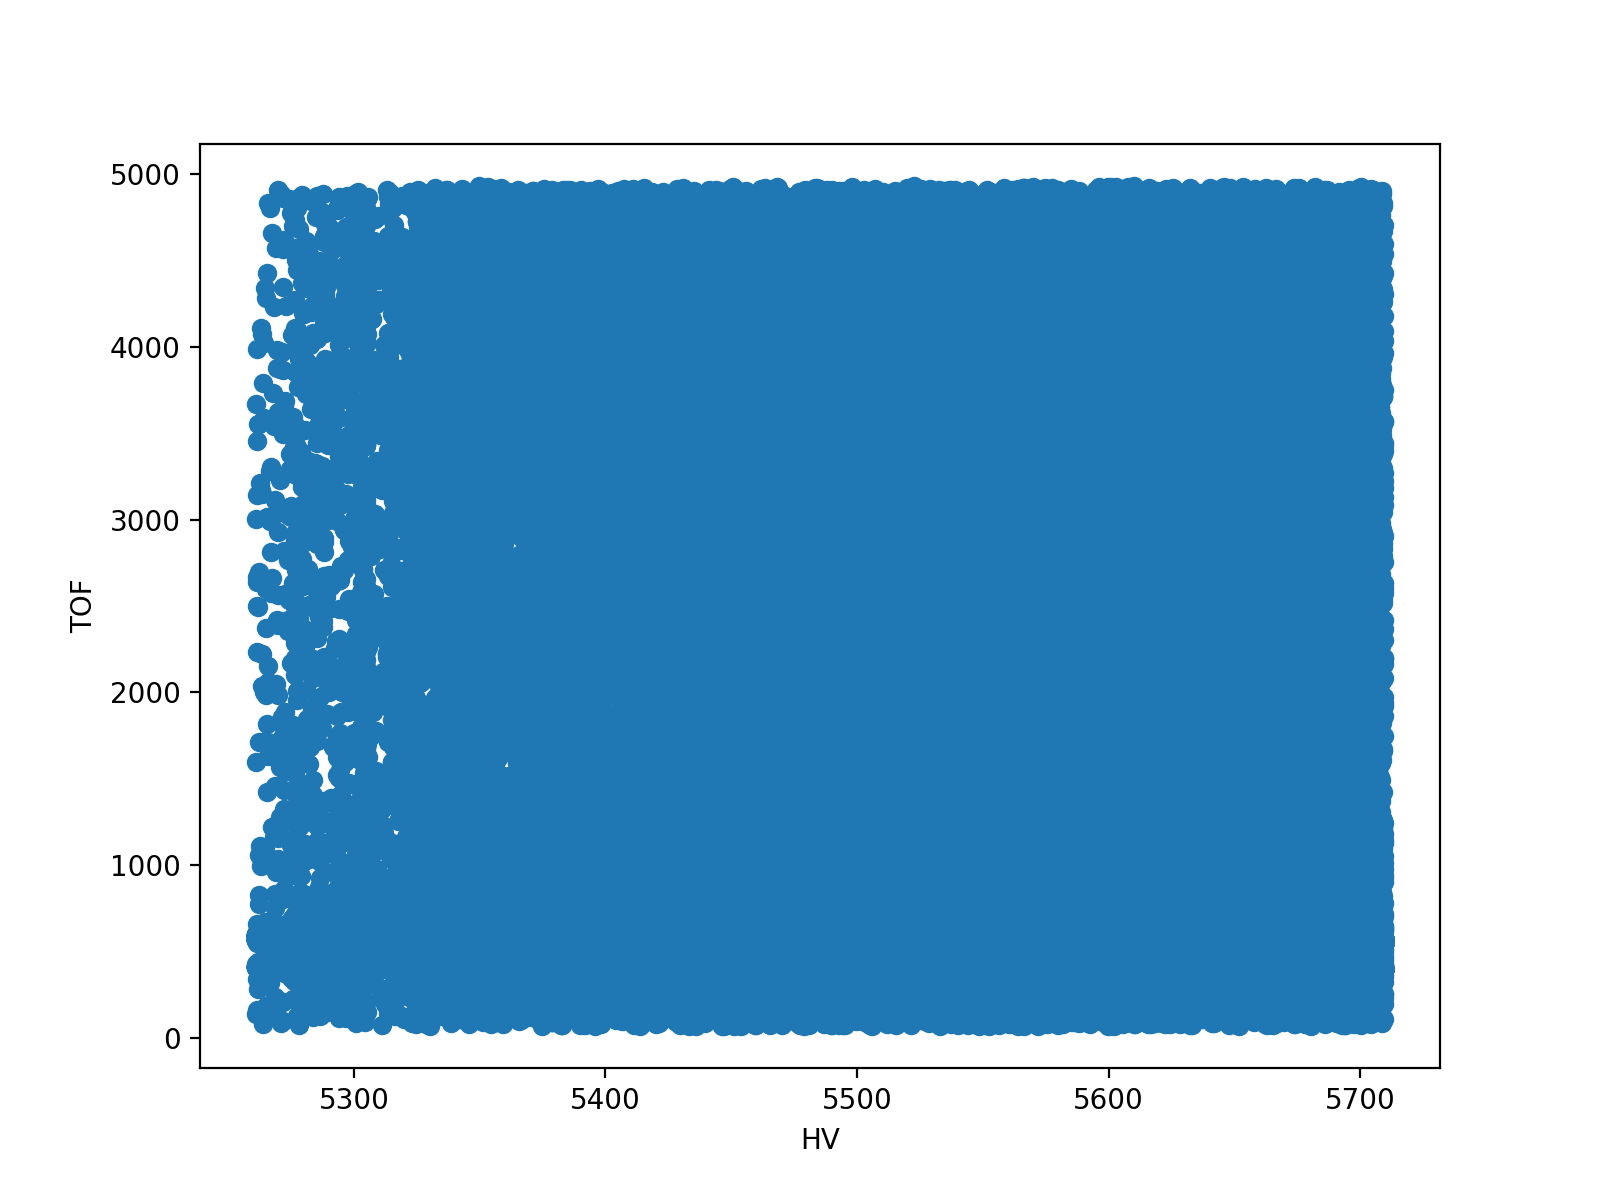

<IPython.core.display.Javascript object>


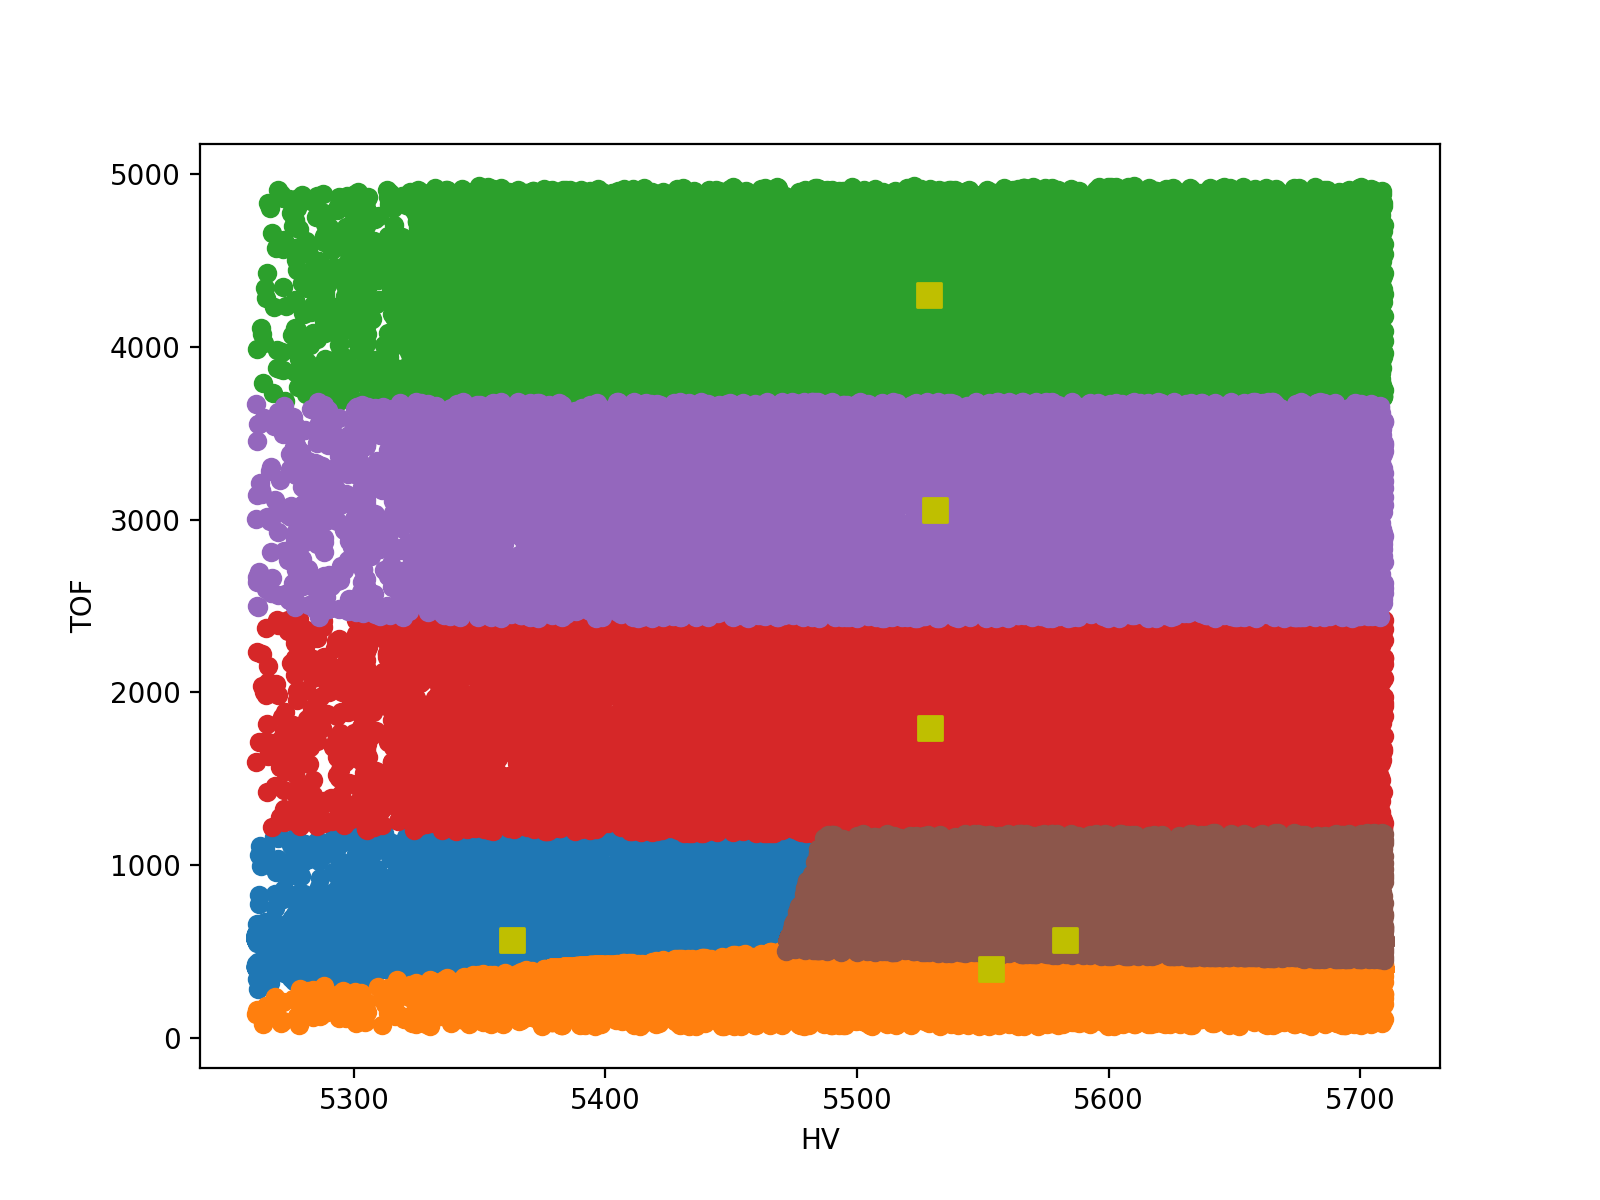

In [88]:
Z = np.append(np.expand_dims(dld_highVoltage, axis=1), np.expand_dims(dld_t, axis=1), axis=1)
Z = np.float32(Z)
num_k = 6
# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(Z, num_k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)


# Plot the data
# fig1, ax1 = plt.subplots(figsize=(8, 6))
# plt.scatter(dld_highVoltage, dld_t)
# plt.xlabel('HV'),plt.ylabel('TOF')
# plt.show()

fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(num_k):
    A = Z[label.ravel()==i]
    plt.scatter(A[:,0],A[:,1])
plt.scatter(center[:,0], center[:,1],s = 80, c = 'y', marker = 's')

plt.xlabel('HV'),plt.ylabel('TOF')
plt.show()

In [65]:
heatmap = heatmap_v_log

In [66]:
print(np.max(heatmap))
print(heatmap.shape[0]*heatmap.shape[1])
print(np.count_nonzero(heatmap==0))
print(heatmap.shape[0]*heatmap.shape[1] - np.count_nonzero(heatmap==0))

7.8674885686991285
960000
942520
17480


<IPython.core.display.Javascript object>


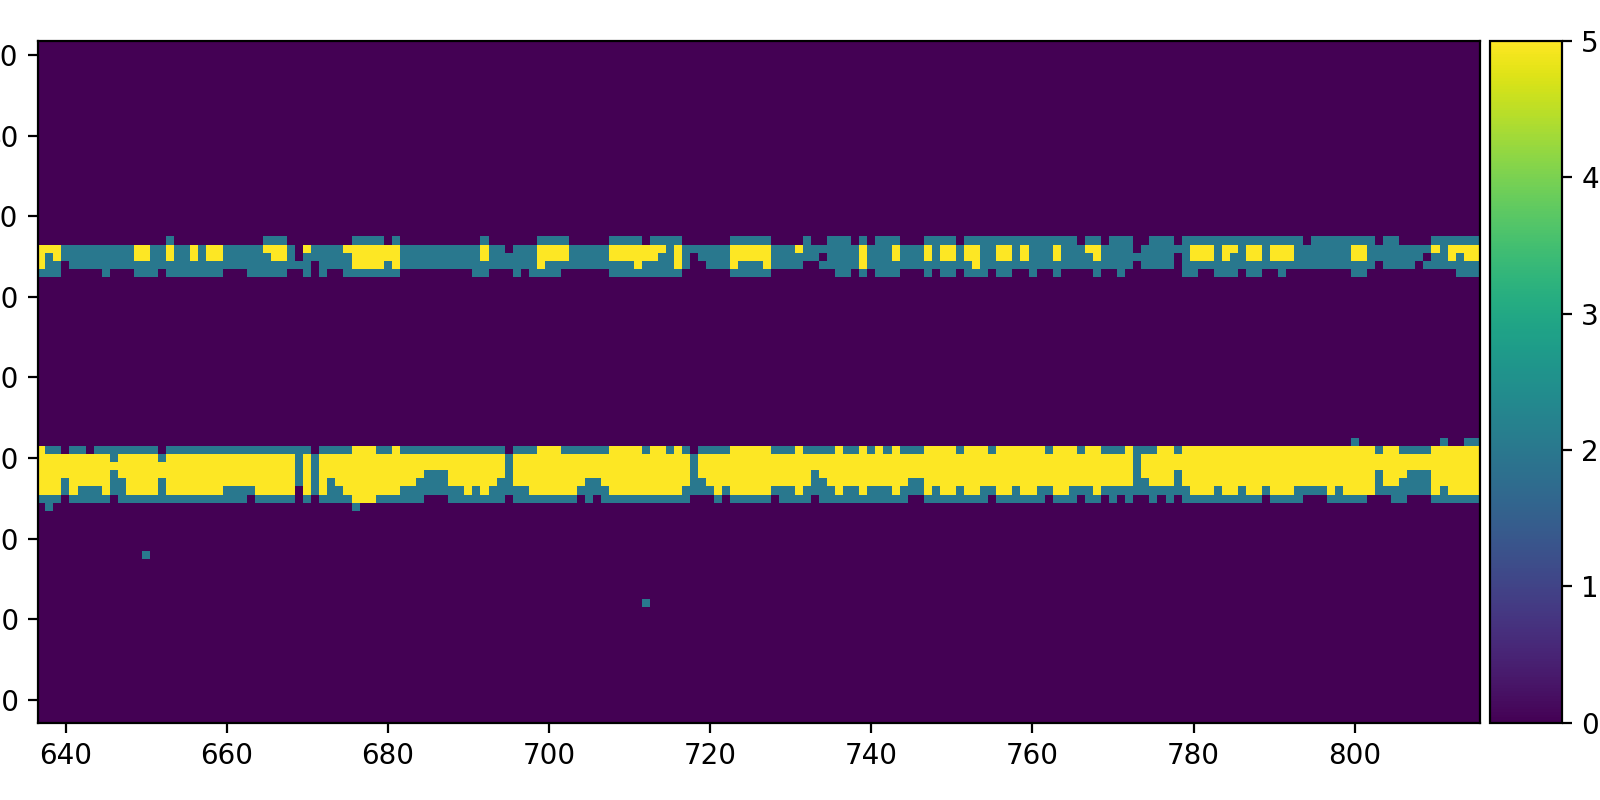

C:\Users\APTUser\.conda\envs\oxcart3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


In [67]:
maxi =  np.max(heatmap)
image = np.copy(heatmap.T) / maxi

h, w = image.shape

# reshape to 1D array
image_2d = image.reshape(h*w, 1)

# set number of colors
numcolors = 3

# do kmeans processing
kmeans_cluster = cluster.KMeans(n_clusters=int(numcolors))
kmeans_cluster.fit(image_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

# need to scale result back to range 0-255
newimage = cluster_centers[cluster_labels].reshape(h, w) * maxi
newimage = newimage.astype('uint8')

# threshold to keep only middle gray values
lower = (1)
upper = (maxi)
thresh = cv2.inRange(newimage, lower, upper)

# get contours and corresponding areas and indices
cntrs_info = []
contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
index=0
for cntr in contours:
    area = cv2.contourArea(cntr)
    cntrs_info.append((index,area))
    index = index + 1

# sort contours by area
def takeSecond(elem):
    return elem[1]
cntrs_info.sort(key=takeSecond, reverse=True)

# draw two largest contours as white filled on black background
result = np.zeros_like(newimage)
index_first = cntrs_info[0][0]
cv2.drawContours(result,[contours[index_first]],0,(maxi),-1)
index_second = cntrs_info[1][0]
cv2.drawContours(result,[contours[index_second]],0,(maxi),-1)

# display result
fig1, ax1 = plt.subplots(figsize=(8, 4))

io.imshow(newimage)
io.show()
# io.imshow(thresh)
# io.show()
# io.imshow(result)
# io.show()

# save kmeans clustered image and layer 3
# io.imsave('lung_kmeans.gif', newimage)
# io.imsave('lung_kmeans_thresh.gif', thresh)
# io.imsave('lung_kmeans_lungs.gif', result)

(3, 1200)


<IPython.core.display.Javascript object>


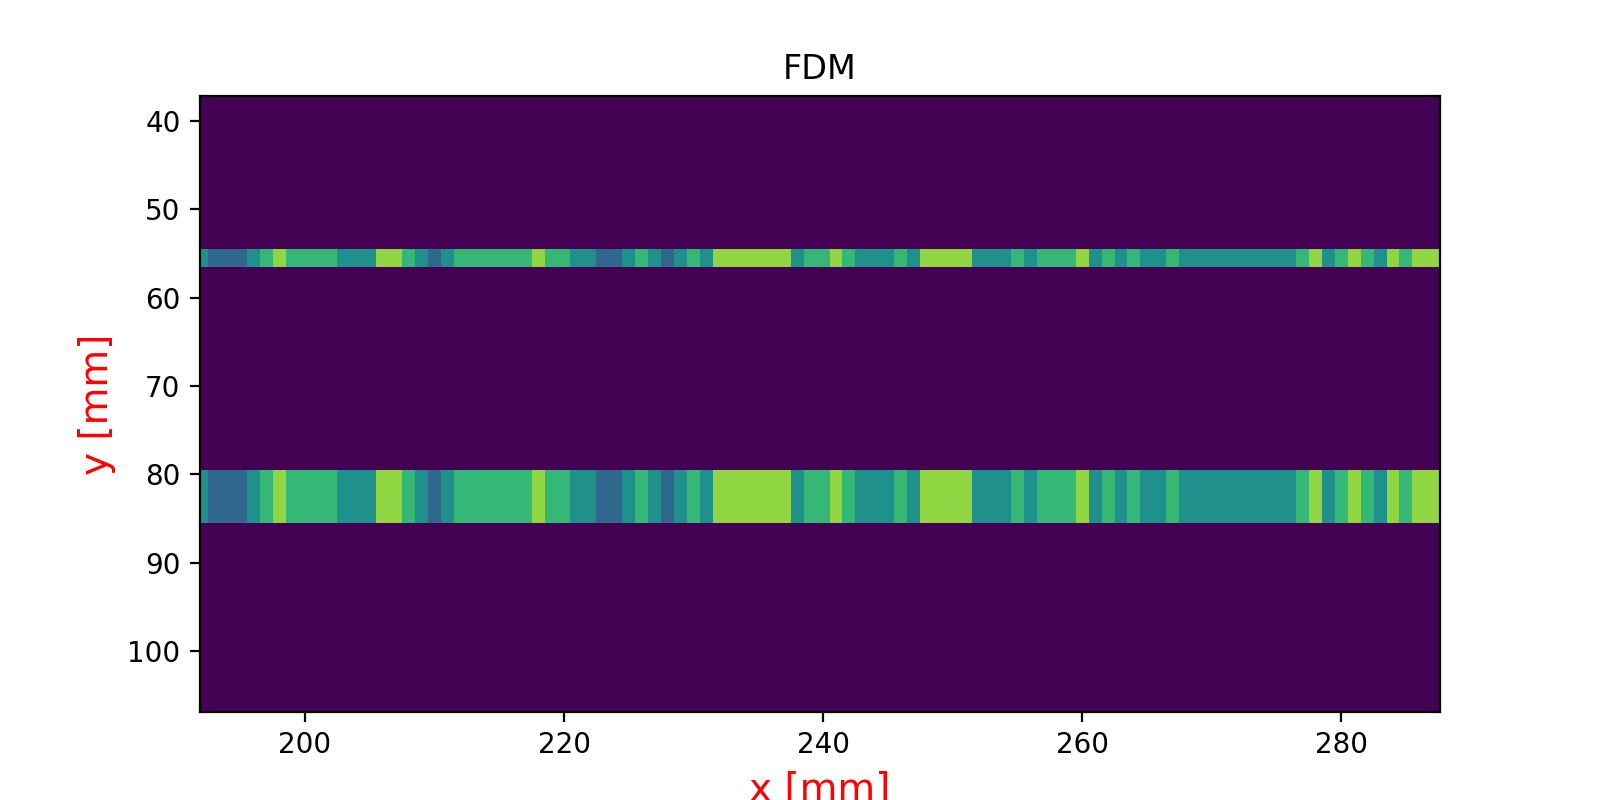

In [69]:
X = np.copy(heatmap.T)
k = 3
pixel_values = np.float32(X)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

ret, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
labelss = labels.flatten()
print(centers.shape)
segmented_image = centers[labelss]
segmented_image = segmented_image.reshape((X.shape))
fig1, ax1 = plt.subplots(figsize=(8, 4))
plt.imshow(segmented_image)
plt.show()